In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
ab = '../talon/human_talon_abundance.tsv'
ver = 'v40_cerberus'

## PolyA gene detection at 0, 1, and 100 TPM


In [3]:
df = pd.read_csv(ab, sep='\t')
df, inds = get_tpm_table(df,
                   how='gene',
                   gene_subset='polya',
                   min_tpm=0)

gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', ver=ver)

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.index)

print('Detected {} / {} ({:.3}%) annotated polyA genes'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

tpm_df = df.copy(deep=True)
tpm_dfs = []
tpm_dfs.append(tpm_df)
tpm_dfs.append(tpm_df.loc[(tpm_df >= 1).any(axis=1)])
tpm_dfs.append(tpm_df.loc[(tpm_df >= 100).any(axis=1)])

det_df = pd.DataFrame()
for df, tpm in zip(tpm_dfs, [0,1,100]):
    gene_df, _, _ = get_gtf_info(how='gene', subset='polya', ver=ver, add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'gname', 'biotype_category']]

    df.reset_index(inplace=True)
    df = df.merge(gene_df, how='left', on='gid_stable')

    df = df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
    df.rename({'gid_stable':'obs_counts'}, axis=1, inplace=True)

    gene_df = gene_df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
    gene_df.rename({'gid_stable':'annot_counts'}, axis=1, inplace=True)
    df = df.merge(gene_df, how='left', left_index=True, right_index=True)

    df['perc'] = (df.obs_counts/df.annot_counts)*100
    df = df.sort_values(by='perc', ascending=False)
    df['tpm_thresh'] = tpm
    det_df = pd.concat([det_df, df])
    
det_df = det_df.reset_index()
det_df.head()

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1478: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1477: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Applying gene type and novelty subset
Number of genes reported: 39681
Detected 39681 / 52274 (75.9%) annotated polyA genes


,biotype_category,obs_counts,annot_counts,perc,tpm_thresh
0,protein_coding,19246,19988,96.287773,0
1,lncRNA,12715,17748,71.641875,0
2,pseudogene,7720,14538,53.102215,0
3,protein_coding,18727,19988,93.691215,1
4,lncRNA,10713,17748,60.361731,1


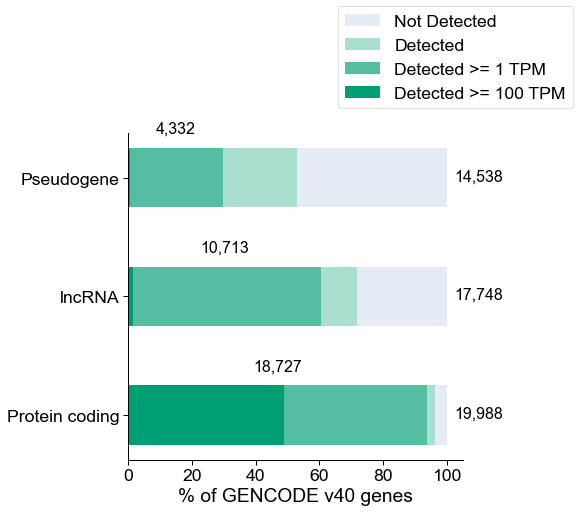

In [12]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(6,6))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
ic_colors, order = get_ic_nov_colors()
gray = get_sector_colors()[0]['simple']
c = ic_colors['Known']
cats = [100,1,0]
c_dict, order = get_shade_colors(c, cats)
order.reverse()
biotypes = ['protein_coding', 'lncRNA', 'pseudogene']
b_dict = {'protein_coding': 'Protein coding',
          'lncRNA': 'lncRNA',
          'pseudogene': 'Pseudogene'}

# https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
def add_n(rects, label):
    ax = plt.gca()
    for rect in rects:
        # height = rect.get_height()
        x = rect.get_y()+rect.get_height()/2.5
        y = rect.get_width()*1.1
        ax.text(y,x,
                '{:,}'.format(label),
                ha='center', va='bottom', size=16)
        
def add_n_2(rects, label):
    ax = plt.gca()
    for rect in rects:
        # height = rect.get_height()
        x = rect.get_y()+rect.get_height()*1.2
        y = rect.get_width()/2
        ax.text(y,x,
                '{:,}'.format(label),
                ha='center', va='bottom', size=16)

for b in biotypes:
    x = b_dict[b]
    y = 0
    rects = plt.barh(x, [100], color=gray, height=0.5)
    # add total number of genes
    n = det_df.loc[(det_df.biotype_category == b)&(det_df.tpm_thresh==1), 'annot_counts'].tolist()[0]
    add_n(rects, n)
    
    for c in order:
        curr_y = det_df.loc[(det_df.biotype_category == b)&(det_df.tpm_thresh==c), 'perc'].tolist()[0]
        rects = plt.barh(x, [curr_y], color=c_dict[c], height=0.5)
        if c == 1:
            n = det_df.loc[(det_df.biotype_category == b)&(det_df.tpm_thresh==1), 'obs_counts'].tolist()[0]
            add_n_2(rects, n)
        y = y+curr_y
    


leg_labels = ['Not Detected', 'Detected', 'Detected >= 1 TPM', 'Detected >= 100 TPM']
plt.legend(leg_labels, bbox_to_anchor=(.6, 1.05))
ax = plt.gca()
leg = ax.get_legend()

# plt.yticks(rotation=90)

# plt.ylabel('Biotype')
plt.xlabel('% of GENCODE v40 genes')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fname = 'figures/gene_det_by_biotype.png'
plt.savefig(fname, dpi=500, bbox_inches='tight')
fname = 'figures/gene_det_by_biotype.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

## PolyA gene detection

What fraction of polyA genes from the annotation do we detect with >= 1 TPM in any library?

In [3]:
df = pd.read_csv(ab, sep='\t')
df, inds = get_tpm_table(df,
                   how='gene',
                   min_tpm=1,
                   gene_subset='polya')

gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', ver=ver)

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.index)

print('Detected {} / {} ({:.3}%) annotated polyA genes'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1463: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1462: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Number of genes reported: 33772
Detected 33772 / 52274 (64.6%) annotated polyA genes


In [4]:
gene_df, _, _ = get_gtf_info(how='gene', subset='polya', ver=ver, add_stable_gid=True)
gene_df = gene_df[['gid_stable', 'gname', 'biotype_category']]

df.reset_index(inplace=True)
df = df.merge(gene_df, how='left', on='gid_stable')

df = df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
df.rename({'gid_stable':'obs_counts'}, axis=1, inplace=True)

gene_df = gene_df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
gene_df.rename({'gid_stable':'annot_counts'}, axis=1, inplace=True)
df = df.merge(gene_df, how='left', left_index=True, right_index=True)

df['perc'] = (df.obs_counts/df.annot_counts)*100
df = df.sort_values(by='perc', ascending=False)
df

,obs_counts,annot_counts,perc
biotype_category,,,
protein_coding,18727,19988,93.691215
lncRNA,10713,17748,60.361731
pseudogene,4332,14538,29.797771


In [7]:
df.reset_index(inplace=True)

In [5]:
c = get_ic_nov_colors()[0]['Known']
c_dict, order = get_shade_colors(c, ['protein_coding', 'lncRNA', 'pseudogene'])

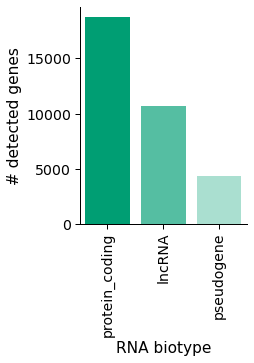

In [8]:
# plotting
sns.set_context('paper', font_scale=1.6)
plt.figure(figsize=(3,4))


ax = sns.barplot(data=df, y='obs_counts', x='biotype_category',
                 palette=c_dict, order=order,
                 saturation=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = 'RNA biotype'
ylabel = '# detected genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
ax.tick_params(axis="x", rotation=90)


# fname = '{}_{}_support.png'.format(opref, feat)
# plt.savefig(fname, dpi=500, bbox_inches='tight')

How many polyA genes do we detect >= 100 TPM in any 1 sample? 

In [4]:
df = pd.read_csv(ab, sep='\t')
df, inds = get_tpm_table(df,
                   groupby='sample',
                   how='gene',
                   min_tpm=100,
                   gene_subset='polya')


gene_df, _, _ = get_gtf_info(how='gene', subset='polya', ver=ver, add_stable_gid=True)
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.index)

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1463: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1462: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 100 tpm: 11176
Applying gene type and novelty subset
Averaging over biosample
Found 50 total samples
Number of genes reported: 10131


In [5]:
print('Detected {} / {} ({:.3}%) annotated polyA genes'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

gene_df, _, _ = get_gtf_info(how='gene', subset='polya', ver=ver, add_stable_gid=True)
gene_df = gene_df[['gid_stable', 'gname', 'biotype_category']]

df.index.name = 'annot_gene_id'
df.reset_index(inplace=True)
df['gid_stable'] = cerberus.get_stable_gid(df, 'annot_gene_id')
df = df.merge(gene_df, how='left', on='gid_stable')

df = df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
df.rename({'gid_stable':'obs_counts'}, axis=1, inplace=True)

gene_df = gene_df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
gene_df.rename({'gid_stable':'annot_counts'}, axis=1, inplace=True)
df = df.merge(gene_df, how='left', left_index=True, right_index=True)

df['perc'] = (df.obs_counts/df.annot_counts)*100
df = df.sort_values(by='perc', ascending=False)
df

Detected 10131 / 52274 (19.4%) annotated polyA genes


,obs_counts,annot_counts,perc
biotype_category,,,
protein_coding,9776,19988,48.909346
lncRNA,254,17748,1.431147
pseudogene,101,14538,0.694731


In [27]:
df.head()

biosample,index,a673,adipose,adrenal gland,brain,caco2,calu3,colon,gm12878,h1,...,ovary,panc1,pc3,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11
0,ENSG00000000003.14,91.502783,118.123552,64.993329,11.302698,347.757386,170.246449,244.050202,0.199761,161.354309,...,95.081279,15.788161,75.053876,115.327269,121.852699,81.407854,149.271547,74.879355,17.373152,131.196822
1,ENSG00000000419.12,42.717698,18.387157,34.326836,27.202421,126.812943,68.914232,18.162833,81.267186,18.462523,...,18.565741,31.576322,28.866875,35.936605,48.384465,37.407601,37.823395,35.827986,14.561838,22.246875
2,ENSG00000000460.16,30.518670,1.671560,3.365819,3.748927,17.822383,40.940526,3.963509,42.876967,44.102917,...,3.738679,16.419687,3.149114,25.639317,18.341192,2.197551,4.647109,5.210468,3.562550,30.262557
3,ENSG00000000938.12,0.000000,50.703977,4.205407,4.691764,0.000000,0.000000,1.995934,83.473252,0.580638,...,2.752435,0.000000,0.000000,0.000000,1.369208,0.634120,0.830925,0.000000,11.932473,0.738960
4,ENSG00000000971.15,2.592035,48.475231,31.232974,17.980357,0.000000,23.877434,18.353658,0.000000,0.000000,...,221.288445,0.000000,2.624261,3.771192,0.000000,21.303144,32.078505,0.000000,116.995038,0.000000


In [10]:
gene_df, _, _ = get_gtf_info(how='gene', subset='polya', ver=ver, add_stable_gid=True)
gene_df = gene_df[['gid_stable', 'gname', 'biotype']]
df = df.merge(gene_df, how='left', on='gid_stable')

In [11]:
df.to_csv('polya_genes_100tpm.tsv', sep='\t', index=False)

In [12]:
df = pd.read_csv('polya_genes_100tpm.tsv', sep='\t')

## How many genes of each biotype category are there in the annotation and detected by us?

In [4]:
# get detected genes w/o subsetting on polyA genes
df = pd.read_csv(ab, sep='\t')
df, _ = get_tpm_table(df,
                   how='gene',
                   min_tpm=1)
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', ver=ver)

df = df.merge(gene_df, how='left', left_index=True, right_on='gid')
temp = df[['gid', 'biotype_category']].groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

Calculating gene TPM values
Subsetting for novelty categories ['Known']


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1376: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1375: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Number of genes reported: 36032


,biotype_category,detected_counts,gencode_counts,prop_detected
0,lncRNA,7272,17748,0.409736
4,pseudogene,3997,14538,0.274935
2,other,1664,7391,0.225139
1,miRNA,305,1879,0.162320
3,protein_coding,1262,19988,0.063138


In [6]:
print(1664+305)
print(7391+1879)
print(1969/9270)

1969
9270
0.21240560949298815


## How many genes in other biotype categories do we detect and what proportion of the annotation does this represent?

In [14]:
temp = df[['gid', 'biotype', 'biotype_category']].groupby(['biotype', 'biotype_category']).count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_counts, on='biotype', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)

## GO on *protein coding* genes that are not detected at >= 1 TPM

In [ ]:
# get detected genes w/o subsetting on polyA genes
df = pd.read_csv(ab, sep='\t')
df, _ = get_tpm_table(df,
                   how='gene',
                   min_tpm=1, 
                   gene_subset='polya')
df['detected'] = True

gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', ver=ver)
df = df.merge(gene_df, how='outer', left_index=True, right_on='gid')
df.detected = df.detected.fillna(False)

print(len(df.index))
df = df.loc[df.biotype_category == 'protein_coding']
print(len(df.index))

In [ ]:
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]

gids = df.loc[~df.detected, 'gid'].str.rsplit('.', n=1, expand=True)[0].to_frame()
gids = gids.squeeze().str.strip().tolist()
gids = bm.query(dataset='hsapiens_gene_ensembl',
           attributes=['ensembl_gene_id', 'external_gene_name'],
           filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description='undet_genes',
                outdir='undet_genes_GO',
                cutoff=0.5)

## How many biosamples do we detect each detected gene in?


Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1478: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1477: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 599976
# genes >= 1 tpm: 292060
Applying gene type and novelty subset
Number of genes reported: 33772
Found 50 total samples


biosample,a673,adipose,adrenal gland,brain,caco2,calu3,colon,gm12878,h1,h1_de,...,panc1,pc3,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11,n_samples
ENSG00000000003,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,41
ENSG00000000005,False,True,False,True,False,False,True,False,True,False,...,False,False,False,True,False,True,False,True,True,16
ENSG00000000419,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,50
ENSG00000000457,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,50
ENSG00000000460,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285986,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
ENSG00000285987,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3
ENSG00000285988,False,False,False,False,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,True,11
ENSG00000285990,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,7


<Figure size 432x288 with 0 Axes>

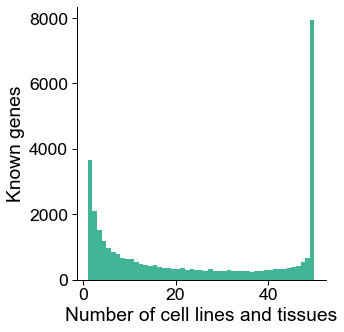

In [ ]:
df = pd.read_csv(ab, sep='\t')
plot_biosamp_det(df,
                 how='gene',
                 min_tpm=1,
                 gene_subset='polya',
                 sample=None,
                 groupby='sample',
                 nov=['Known'],
                 opref='figures/human')